In [1]:
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential,Model,initializers,layers,Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
def Channel_Shuffle(x,groups):
    g = groups
    batch, height, width, channels = x.shape
    x = tf.reshape(x, [-1, height, width, g, channels // g])
    x = tf.transpose(x, perm = [0, 1, 2, 4, 3])
    x = tf.reverse(x,[-1])
    x = tf.reshape(x, [-1, height, width, channels])
    return x

def yBlock_st_1(x,filter_size):
    x1,x2=layers.Lambda(lambda x: tf.split(x,num_or_size_splits=2,axis=3))(x)

    x1=layers.Conv2D(filters=filter_size/4,kernel_size=1,strides=1,padding='same')(x1)
    x1=layers.BatchNormalization()(x1)
    x1=layers.ReLU(max_value=6)(x1)
    x1=layers.DepthwiseConv2D(kernel_size=3,strides=1,padding='same')(x1)
    x1=layers.BatchNormalization()(x1)
    x1=layers.Conv2D(filters=filter_size,kernel_size=1,strides=1,padding='same')(x1)
    x1=layers.BatchNormalization()(x1)
    x1=layers.ReLU(max_value=6)(x1)
    
    x3=layers.Concatenate()([x1,x2])
    x3=layers.Lambda(lambda x:Channel_Shuffle(x,groups=4))(x3)
    return x3


def yBlock_st_2(x,filter_size):
    x2=layers.Conv2D(filters=filter_size/4,kernel_size=1,strides=1,padding='same')(x)
    x2=layers.BatchNormalization()(x2)
    x2=layers.ReLU(max_value=6)(x2)
    x2=layers.DepthwiseConv2D(kernel_size=3,strides=2,padding='same')(x2)
    x2=layers.BatchNormalization()(x2)
    x2=layers.Conv2D(filters=filter_size,kernel_size=1,strides=1,padding='same')(x2)
    x2=layers.BatchNormalization()(x2)
    x2=layers.ReLU(max_value=6)(x2)

    x1=layers.AveragePooling2D(pool_size=2,strides=2,padding='same')(x)
    x1=layers.Conv2D(filters=filter_size,kernel_size=1,strides=1,padding='same')(x1)

    x3=layers.Concatenate()([x1,x2])
    x3=layers.Lambda(lambda x:Channel_Shuffle(x,groups=4))(x3)

    return x3

def Classifier(x,num_classes):
    x=layers.GlobalAveragePooling2D()(x)
    x=layers.Dense(units=num_classes,activation='sigmoid')(x)
    return x

In [3]:
input=Input(shape=(224,224,3))
x=layers.Conv2D(filters=24,kernel_size=3,strides=2,padding='same')(input)
x=layers.MaxPool2D(pool_size=3,strides=2,padding='same')(x)
print(x.shape)

x=yBlock_st_2(x,116)
print(x.shape)

x=yBlock_st_1(x,116)
x=yBlock_st_1(x,116)
x=yBlock_st_1(x,116)
print(x.shape)

x=yBlock_st_2(x,232)
print(x.shape)

x=yBlock_st_1(x,232)
x=yBlock_st_1(x,232)
x=yBlock_st_1(x,232)
x=yBlock_st_1(x,232)
x=yBlock_st_1(x,232)
x=yBlock_st_1(x,232)
x=yBlock_st_1(x,232)
print(x.shape)

x=yBlock_st_2(x,464)
print(x.shape)
x=yBlock_st_1(x,464)
x=yBlock_st_1(x,464)
x=yBlock_st_1(x,464)
print(x.shape)

x=layers.Conv2D(filters=1024,kernel_size=1,strides=1,padding='same')(x)
print(x.shape)

x=Classifier(x,10)

model = tf.keras.models.Model(input,x)

(None, 56, 56, 24)
(None, 28, 28, 232)
(None, 28, 28, 232)
(None, 14, 14, 464)
(None, 14, 14, 464)
(None, 7, 7, 928)
(None, 7, 7, 928)
(None, 7, 7, 1024)


In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 24  672         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 24)   0           ['conv2d[0][0]']                 
                                                                                              

In [7]:
dir=r'D:\dataset\butterfly\train'
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
dir,
labels="inferred",
label_mode="categorical",
class_names=None,
color_mode="rgb",
batch_size=16,
image_size=(224, 224),
shuffle=True,
seed=10,
validation_split=0.1,
subset='training',
interpolation="gaussian",
follow_links=False,
crop_to_aspect_ratio=False,)


validation_ds=tf.keras.preprocessing.image_dataset_from_directory(
dir,
labels="inferred",
label_mode="categorical",
class_names=None,
color_mode="rgb",
batch_size=16,
image_size=(224, 224),
shuffle=True,
seed=10,
validation_split=0.1,
subset='validation',
interpolation="gaussian",
follow_links=False,
crop_to_aspect_ratio=False,)

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

model_checkpoint_best_path=r'D:\GitHub_repo\CNN-Model-Application\save_weights\yblock_relu6/'
model_checkpoint_best=ModelCheckpoint(filepath=model_checkpoint_best_path,monitor='val_acc',save_best_only=True,save_weights_only=True,save_freq='epoch')
early_stopping=EarlyStopping(monitor='val_acc',patience=30,min_delta=1e-4)


lr_rate=tf.keras.optimizers.schedules.ExponentialDecay(1e-3, 10000, 0.97, staircase=False, name=None)

    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_rate),loss='categorical_crossentropy',metrics=['acc',tf.keras.metrics.Precision(name='precision')\
                          ,tf.keras.metrics.Recall(name='recall')],)

history=model.fit(train_ds,validation_data=validation_ds,epochs=100,batch_size=16,verbose=1,callbacks=[model_checkpoint_best])

Found 1257 files belonging to 10 classes.
Using 1132 files for training.
Found 1257 files belonging to 10 classes.
Using 125 files for validation.
Epoch 1/100
71/71 [==============================] - 15s 104ms/step - loss: 2.0838 - acc: 0.4567 - precision: 0.1827 - recall: 0.8746 - val_loss: 2.2836 - val_acc: 0.2000 - val_precision: 0.1083 - val_recall: 0.4480
Epoch 2/100
71/71 [==============================] - 5s 76ms/step - loss: 1.1942 - acc: 0.6378 - precision: 0.2073 - recall: 0.9435 - val_loss: 2.3101 - val_acc: 0.2160 - val_precision: 0.0985 - val_recall: 0.5200
Epoch 3/100
71/71 [==============================] - 5s 63ms/step - loss: 0.8263 - acc: 0.7447 - precision: 0.2157 - recall: 0.9717 - val_loss: 2.2341 - val_acc: 0.1520 - val_precision: 0.1346 - val_recall: 0.5200
Epoch 4/100
71/71 [==============================] - 5s 74ms/step - loss: 0.6050 - acc: 0.8136 - precision: 0.2274 - recall: 0.9823 - val_loss: 2.3057 - val_acc: 0.2880 - val_precision: 0.1297 - val_recall: 0.

In [42]:
model.load_weights(model_checkpoint_best_path)
test_loss,test_acc,test_presicion,test_recall=model.evaluate(validation_ds,verbose=1)

8/8 [==============================] - 1s 34ms/step - loss: 0.2585 - acc: 0.9280 - precision: 0.2759 - recall: 1.0000


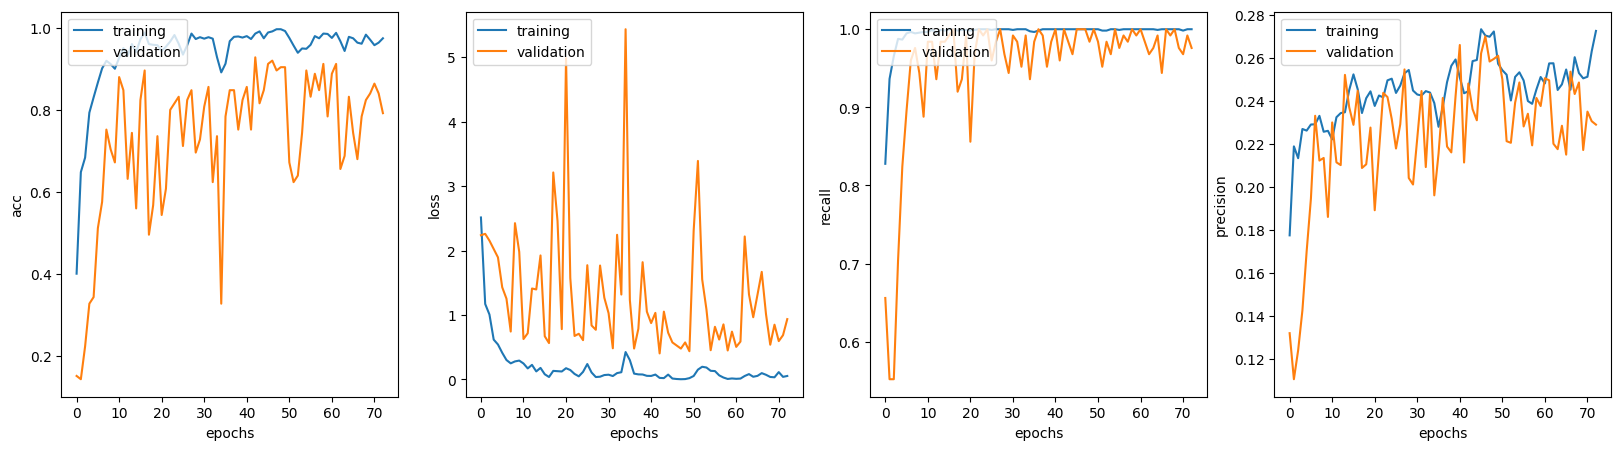

In [40]:
plt.figure(figsize=(20,5))

plt.subplot(1,4,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['training','validation'],loc='upper left')

plt.subplot(1,4,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['training','validation'],loc='upper left')

plt.subplot(1,4,3)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.ylabel('recall')
plt.xlabel('epochs')
plt.legend(['training','validation'],loc='upper left')

plt.subplot(1,4,4)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.ylabel('precision')
plt.xlabel('epochs')
plt.legend(['training','validation'],loc='upper left')
plt.show()